In [2]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [3]:
palette = {
    '1.5C': pyam.plotting.PYAM_COLORS["AR6-C1"],
    '1.5C-OS': pyam.plotting.PYAM_COLORS["AR6-C2"],
    '2C': pyam.plotting.PYAM_COLORS["AR6-C3"],
}

# Load Data

In [4]:
data_path = pathlib.Path('../data')

In [5]:
meta = pd.merge(
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv'),
    pd.read_csv(data_path / 'additional_analysis_metadata.csv'),
    on=['model', 'scenario'], how='inner'
)

# Plot Utilities

In [6]:
variable_templates = [
    'AR6 climate diagnostics|Infilled|Emissions|{gas}', # as reported in AR6
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}|Direct Only', # reanalyzed by OSCAR
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}', # reanalyzed by OSCAR including NGHGI adjustment 
]

In [7]:
def figure_data(data, variable_start, gas, name):
    print(name)
    cols = [variable_start + template.format(gas=gas) for template in variable_templates]
    headers = ['AR6 Statistics', 'Pathways with OSCAR Direct Effects', 'Pathways with OSCAR Direct & Indirect Effects']
    for col in cols:
        if not col in data:
            raise ValueError(f'{col} not in data columns')
    ret = (
        data
        .query("Category in ['C1', 'C2', 'C3']")
        .replace({'Category': {'C1': '1.5C', 'C2': '1.5C-OS', 'C3': '2C'}})
        .rename(columns={c: h for c, h in zip(cols, headers)})
        [headers + ['Category']]
    )
    ret = (
        ret
        .dropna()
        .sort_values(by='AR6 Statistics', ascending=True)
        .reset_index(drop=True)
        .reset_index()
    )
    return ret

In [143]:
def scatter_compare(
    data, right='Pathways with OSCAR Direct Effects', left="Pathways with OSCAR Direct & Indirect Effects",
    legend={},
):
    fig, ax = plt.subplots(figsize=(8, 8))
    hue = 'Category'
    sns.scatterplot(
        data=data, 
        x=right, y="index", hue=hue, palette=palette,
        label=right,
        marker='o', size=2, #edgecolor='white', linewidths=0.05, 
        ax=ax, 
    )
    sns.scatterplot(
        data=data, 
        x=left, y="index", hue=hue, palette=palette,
        label=left,
        marker='^', size=2,  #edgecolor='k', linewidths=0.05, 
        ax=ax,
    )
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('')
    h, l = ax.get_legend_handles_labels()
    idx = 2 + len(data[hue].unique())
    if legend != {}:
        idxs = [1, 3, 2, 0, 5]
        handles = [h[i] for i in idxs]
        labels = [l[i] for i in idxs]
        ax.legend(handles, labels, **legend)
    else:
        ax.legend().remove()

    return fig, ax

# Cumulative CO2

Carbon Budget from 2020


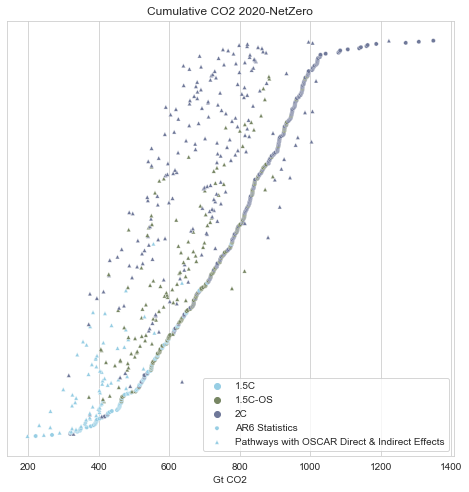

In [160]:
data = figure_data(meta, 'Carbon Budget for ', 'CO2', 'Carbon Budget from 2020')
fig, ax = scatter_compare(
    data, right='AR6 Statistics', left='Pathways with OSCAR Direct & Indirect Effects', 
    legend={'loc': 'best'}
)
ax.set_title('Cumulative CO2 2020-NetZero')
ax.set_xlabel('Gt CO2')
fig.savefig('./files/fig2a1.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


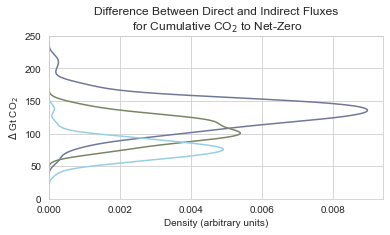

In [161]:
label = 'Difference Between Direct and Indirect Fluxes'
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
data[label] = diff

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=data, y=label, hue="Category", palette=palette, hue_order=list(palette.keys()), multiple="layer", ax=ax)
ax.set_xlabel('Density (arbitrary units)')
ax.set_ylim((0, 250))
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

# changes made for final figure
ax.set_title(label + '\n for Cumulative CO$_2$ to Net-Zero')
ax.set_ylabel('$\Delta$ Gt CO$_2$')
ax.legend().remove()

fig.savefig('./files/fig2a2.pdf', bbox_inches='tight')

In [146]:
data.groupby('Category')[label].quantile((0.05, 0.5, 0.95))

Category      
1.5C      0.05     54.410584
          0.50     74.739290
          0.95     95.916680
1.5C-OS   0.05     73.615450
          0.50    104.439078
          0.95    134.491503
2C        0.05     92.927003
          0.50    131.226768
          0.95    166.528725
Name: Difference Between Direct and Indirect Fluxes, dtype: float64

# Net-zero Year

Net-zero CO2 Year


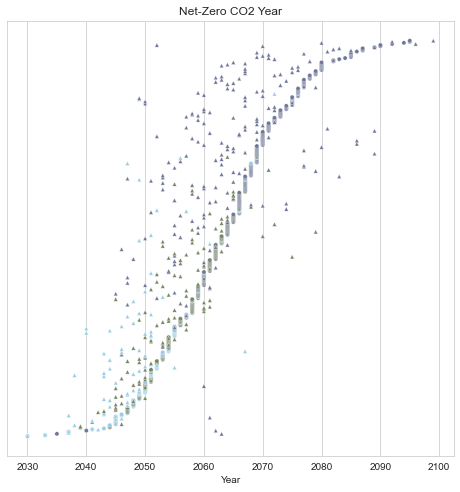

In [157]:
data = figure_data(meta, 'Interpolated Net-Zero Year for ', 'CO2', 'Net-zero CO2 Year')
fig, ax = scatter_compare(
    data, right='AR6 Statistics', left='Pathways with OSCAR Direct & Indirect Effects', 
    legend={},
)
ax.set_title('Net-Zero CO2 Year')
ax.set_xlabel('Year')
fig.savefig('./files/fig2b1.pdf', bbox_inches='tight')

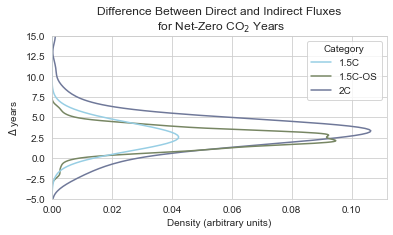

In [158]:
label = 'Difference Between Direct and Indirect Fluxes'
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
data[label] = diff

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=data, y=label, hue="Category", palette=palette, hue_order=list(palette.keys()), multiple="layer", ax=ax)
ax.set_xlabel('Density (arbitrary units)')
ax.set_ylim((-5, 15))

# changes made for final figure
ax.set_title(label + '\n for Net-Zero CO$_2$ Years')
ax.set_ylabel('$\Delta$ years')


fig.savefig('./files/fig2b2.pdf', bbox_inches='tight')

In [20]:
data.groupby('Category')[label].quantile((0.05, 0.5, 0.95))

Category      
1.5C      0.05    1.0
          0.50    3.0
          0.95    5.0
1.5C-OS   0.05    1.0
          0.50    2.0
          0.95    4.0
2C        0.05   -1.0
          0.50    3.0
          0.95    6.6
Name: Difference Between Direct and Indirect Fluxes, dtype: float64